In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage

from tardis.simulation import Simulation
from tardis.io.config_reader import Configuration
from tardis.io.atom_data import AtomData

from astropy import units as u, constants as const

from stardis.plasma import AlphaLine, HMinusDensity, TracingNus, create_splasma
from stardis.opacities import calc_tau_h_minus, calc_tau_e, calc_tau_nus, calc_hminus_density
from stardis.io import read_marcs_to_fv
from stardis.raytrace import calc_weights

Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

(1000.0, 9000.0)

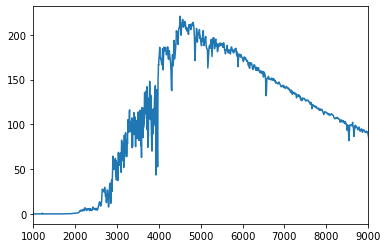

In [2]:
sun_spec = pd.read_csv('data/solar_data/NewGuey2003.txt', skiprows=20, delim_whitespace=True, names=['wave', 'flux'])
sun_spec['wave'] *= 10
sun_spec['flux'] = u.Quantity(sun_spec['flux'].to_numpy(), "W/(m2 nm)").to("erg/(s cm2 AA)").value
plt.plot(sun_spec.wave, sun_spec.flux)
plt.xlim(1000, 9000)

## Model & Atomic Data

In [3]:
adata = AtomData.from_hdf('kurucz_cd23_chianti_H_He.h5')
marcs_model_fv, marcs_abundances_all, temps = read_marcs_to_fv('data/marcs/sun.mod', adata, 30)
adata.prepare_atom_data(marcs_abundances_all.index.tolist())

## Plasma

In [4]:
tracing_wavelength = np.arange(1000, 10000, 10) * u.Angstrom
tracing_nus = tracing_wavelength.to(u.Hz, u.spectral())

splasma = create_splasma(marcs_model_fv, marcs_abundances_all, adata, tracing_nus)

## RT Calculation

In [5]:
tau_h_minus = calc_tau_h_minus(
    h_neutral_density=splasma.ion_number_density.loc[(1, 0)].values,
    temperature=marcs_model_fv.t.values * u.K,
    electron_density=splasma.electron_densities.values,
    wbr_fpath="data/wishart_broad_reinhardt_cross_section.dat",
    tracing_wavelength=tracing_wavelength.value,
    cell_length=marcs_model_fv.cell_length.values,
)

In [6]:
# alpha value (=n x sigma) of each line for all 55 cells
# shape of splasma.alpha_line: (74, 55), splasma has 74 lines (aka atomic transitions)
alpha_line = splasma.alpha_line.reset_index(drop=True).values[::-1]
delta_tau_lines = alpha_line * marcs_model_fv.cell_length.values # shape: (74, 55)

In [7]:
h_minus_density = calc_hminus_density(
    h_neutral_density=splasma.ion_number_density.loc[(1, 0)].values,
    temperature=marcs_model_fv.t.values * u.K,
    electron_density=splasma.electron_densities.values,
    )

In [8]:
tau_e = calc_tau_e(splasma,marcs_model_fv,tracing_nus)

In [9]:
len(marcs_model_fv)

55

In [10]:
len(tracing_nus)

900

In [11]:
tau_h_minus.shape, delta_tau_lines.shape, tau_e.shape

((55, 900), (271741, 55), (55, 900))

In [12]:
# transition doesn't happen at a specific nu due to several factors (changing temperatires, doppler shifts, relativity, etc.)
# so we take a window 2e11 Hz wide - if nu falls within that, we consider it

lines_nu = splasma.lines.nu.values[::-1] # reverse to bring them to ascending order

# search_sorted finds the index before which a (tracing_nu +- 1e11) can be inserted 
# in lines_nu array to maintain its sort order
line_id_starts = lines_nu.searchsorted(tracing_nus.value-1e11)
line_id_ends = lines_nu.searchsorted(tracing_nus.value+1e11)

### Source function

In [13]:
# bb shape: (56, 800000), calculated at each cell boundary
bb_prefactor = (2 * const.h.cgs * tracing_nus ** 3) / const.c.cgs ** 2
bb = bb_prefactor / (
    np.exp(
        (
            (const.h.cgs * tracing_nus)
            / (const.k_B.cgs * temps * u.K)
        ).value
    )
    - 1
)

In [14]:
tw_cm = tracing_wavelength.to("cm")

In [15]:
bbw_prefactor = (2 * const.h.cgs * const.c.cgs ** 2) / (tracing_wavelength) ** 5
bbw = bbw_prefactor / (
    np.exp(
        (
            (const.h.cgs * const.c.cgs)
            / (const.k_B.cgs * tracing_wavelength * temps * u.K)
        )
    )
    - 1
) * 1e-7

In [16]:
tw_cm

<Quantity [1.00e-05, 1.01e-05, 1.02e-05, 1.03e-05, 1.04e-05, 1.05e-05,
           1.06e-05, 1.07e-05, 1.08e-05, 1.09e-05, 1.10e-05, 1.11e-05,
           1.12e-05, 1.13e-05, 1.14e-05, 1.15e-05, 1.16e-05, 1.17e-05,
           1.18e-05, 1.19e-05, 1.20e-05, 1.21e-05, 1.22e-05, 1.23e-05,
           1.24e-05, 1.25e-05, 1.26e-05, 1.27e-05, 1.28e-05, 1.29e-05,
           1.30e-05, 1.31e-05, 1.32e-05, 1.33e-05, 1.34e-05, 1.35e-05,
           1.36e-05, 1.37e-05, 1.38e-05, 1.39e-05, 1.40e-05, 1.41e-05,
           1.42e-05, 1.43e-05, 1.44e-05, 1.45e-05, 1.46e-05, 1.47e-05,
           1.48e-05, 1.49e-05, 1.50e-05, 1.51e-05, 1.52e-05, 1.53e-05,
           1.54e-05, 1.55e-05, 1.56e-05, 1.57e-05, 1.58e-05, 1.59e-05,
           1.60e-05, 1.61e-05, 1.62e-05, 1.63e-05, 1.64e-05, 1.65e-05,
           1.66e-05, 1.67e-05, 1.68e-05, 1.69e-05, 1.70e-05, 1.71e-05,
           1.72e-05, 1.73e-05, 1.74e-05, 1.75e-05, 1.76e-05, 1.77e-05,
           1.78e-05, 1.79e-05, 1.80e-05, 1.81e-05, 1.82e-05, 1.83e-05,
      

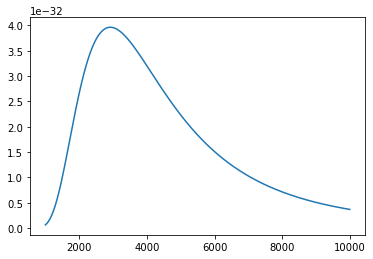

In [17]:
plt.plot(tracing_wavelength,bbw[0])

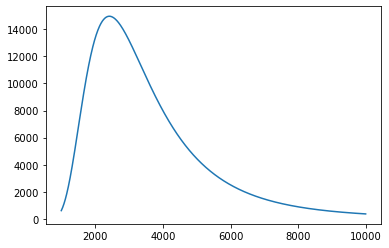

In [18]:
plt.plot(tracing_wavelength,bb[0]*tracing_nus/tracing_wavelength**2)

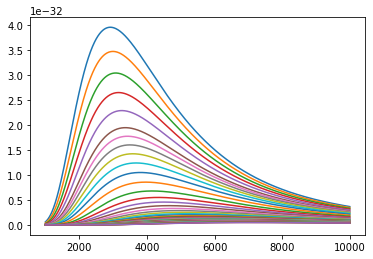

In [19]:
for i in range(55):
    plt.plot(tracing_wavelength,bbw[i])

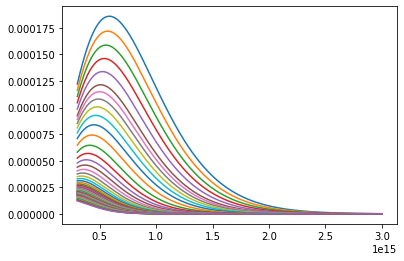

In [20]:
for i in range(55):
    plt.plot(tracing_nus,bb[i])

In [21]:
marcs_model_fv.t.values

array([9806.35, 9551.5 , 9296.55, 9036.15, 8762.  , 8541.4 , 8376.5 ,
       8194.05, 7987.3 , 7747.55, 7466.5 , 7149.05, 6839.05, 6573.35,
       6343.55, 6139.75, 5960.  , 5801.55, 5662.25, 5540.1 , 5432.8 ,
       5338.45, 5255.6 , 5182.65, 5118.55, 5061.5 , 5011.25, 4966.1 ,
       4925.  , 4888.2 , 4854.4 , 4823.45, 4794.75, 4767.8 , 4742.3 ,
       4717.95, 4694.45, 4671.55, 4649.  , 4626.7 , 4604.55, 4582.5 ,
       4560.5 , 4538.45, 4516.15, 4482.95, 4438.65, 4393.8 , 4348.7 ,
       4303.45, 4258.15, 4212.95, 4168.15, 4124.25, 4084.7 ])

In [22]:
bb.shape

(56, 900)

In [23]:
source = bb[1:].value 
delta_source = bb.diff(axis=0).value  # for cells, not boundary

### RT Equation

In [24]:
tau_photo_H = 7.91e-18 * splasma.level_number_density.loc[(1,0,1)] * marcs_model_fv.cell_length.values

tau_photo_C = 7.91e-18/6**2 * splasma.level_number_density.loc[(6,0,1)] * marcs_model_fv.cell_length.values

tau_photo_Si = 7.91e-18/14**2 * splasma.level_number_density.loc[(14,0,1)] * marcs_model_fv.cell_length.values

tau_photo_Mg = 7.91e-18/12**2 * splasma.level_number_density.loc[(12,0,1)] * marcs_model_fv.cell_length.values

tau_photo_Al = 7.91e-18/13**2 * splasma.level_number_density.loc[(13,0,1)] * marcs_model_fv.cell_length.values

tau_photo_C/tau_photo_H;

In [25]:
# I_nu (specific intensity) is calculated at each cell boundary, shape: (56,800000)
I_nu = np.ones((delta_tau_lines.shape[1] + 1, len(tracing_nus))) * -99
I_nu[0] = bb[0]  # the innermost boundary is photosphere
num_of_shells = len(I_nu) - 1

for i in range(len(tracing_nus)):  # iterating over nus (columns)
    nu, line_id_start, line_id_end = (
        tracing_nus[i],
        line_id_starts[i],
        line_id_ends[i],
    )

    if line_id_start != line_id_end:
        delta_tau = delta_tau_lines[line_id_start:line_id_end]
        delta_nu = nu.value - lines_nu[line_id_start:line_id_end]
        #tau_nus = np.zeros(I_nu.shape[0] - 1)
        tau_nus = calc_tau_nus(delta_tau, delta_nu)

    else:
        tau_nus = np.zeros(I_nu.shape[0] - 1)

    for j in range(num_of_shells):  # iterating over cells/shells (rows)
        cur_tau_h_minus = tau_h_minus[j,i]
        curr_tau_e = tau_e[j,i]
        curr_tau_photo = 0
        #curr_tau_rayleigh = tau_rayleigh[j] * nu.value**4
        if nu.value>8.22e14:
            curr_tau_photo += tau_photo_H[j] * (nu.value/8.22e14)**(-3)
        if nu.value>1.7e16:
            curr_tau_photo += tau_photo_C[j] * (nu.value/1.7e16)**(-3)
        if nu.value>1.2e16:
            curr_tau_photo += tau_photo_Si[j] * (nu.value/1.2e16)**(-3)
        if nu.value>1.2e16:
            curr_tau_photo += tau_photo_Mg[j] * (nu.value/1.2e16)**(-3)
        if nu.value>1.2e16:
            curr_tau_photo += tau_photo_Al[j] * (nu.value/1.2e16)**(-3)
        delta_tau_nu = tau_nus[j] + cur_tau_h_minus + curr_tau_photo + curr_tau_e #+ tauross[j] seems to improve
        w0, w1 = calc_weights(delta_tau_nu)

        if tau_nus[j] == 0:
            second_term = 0
        else:
            second_term = w1 * delta_source[j, i] / delta_tau_nu

        I_nu[j + 1, i] = (1 - w0) * I_nu[j, i] + w0 * source[j, i] + second_term # van Noort 2001 eq 14



### Plotting

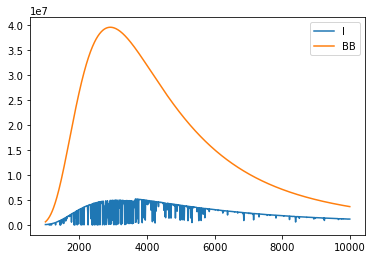

In [26]:
I_lambda = (I_nu[55])*tracing_nus/tracing_wavelength

cur_bb = bb[0]*tracing_nus/tracing_wavelength #TODO: check why 0, shouldn't it be 55 like I_nu?

plt.plot(tracing_wavelength, I_lambda, label="I")
plt.plot(tracing_wavelength, cur_bb, label="BB")
# plt.xlim(4330,4350) # to see 1st feature
# plt.xlim(6500, 6600) # to see last feature
#plt.xlim(2000,10000) 
plt.legend()

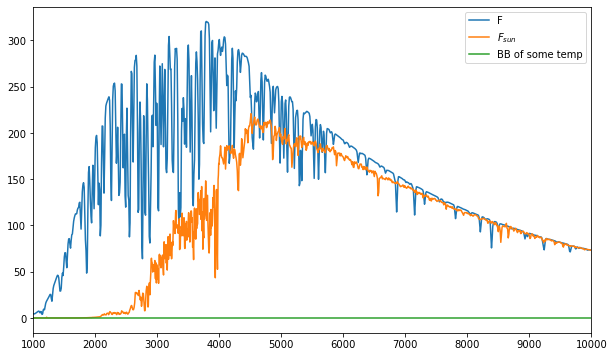

In [27]:
plt.figure(figsize=(10,6))
flux = 2*np.pi*1e-5*ndimage.gaussian_filter1d(I_lambda, 1)
plt.plot(tracing_wavelength, flux, label="F")
plt.plot(sun_spec.wave, sun_spec.flux, label="$F_{sun}$")
plt.plot(tracing_wavelength,bbw[14], label="BB of some temp")

plt.xlim((1000,10000))
plt.legend()

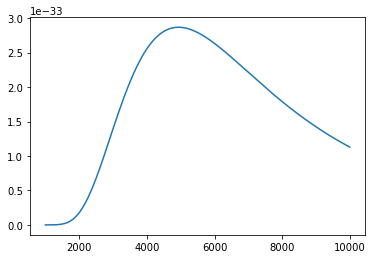

In [28]:
plt.plot(tracing_wavelength,bbw[17], label="BB of some temp")

In [29]:
kappaross_diff = np.diff(marcs_model_fv.kappaross)
kappaross_diff = kappaross_diff[::-1]
kappaross_diff = np.append(kappaross_diff,marcs_model_fv.kappaross[54])
kappaross_diff

array([-4.72350e-04, -5.83500e-04, -7.21600e-04, -8.91600e-04,
       -1.10210e-03, -1.36310e-03, -1.68645e-03, -2.08680e-03,
       -2.58405e-03, -2.26800e-03, -1.77100e-03, -1.97100e-03,
       -2.19400e-03, -2.44250e-03, -2.71750e-03, -3.02600e-03,
       -3.37050e-03, -3.75300e-03, -4.18150e-03, -4.65650e-03,
       -5.19000e-03, -5.79200e-03, -6.46400e-03, -7.21350e-03,
       -8.06050e-03, -9.01700e-03, -1.01045e-02, -1.13290e-02,
       -1.27550e-02, -1.44550e-02, -1.65450e-02, -1.92750e-02,
       -2.30450e-02, -2.86100e-02, -3.71950e-02, -5.08350e-02,
       -7.24900e-02, -1.06400e-01, -1.59130e-01, -2.42100e-01,
       -3.72650e-01, -6.05650e-01, -1.02165e+00, -1.50595e+00,
       -1.89335e+00, -2.19685e+00, -2.46115e+00, -2.72085e+00,
       -3.00000e+00, -5.19600e+00, -8.15000e+00, -1.02380e+01,
       -1.29420e+01, -1.63915e+01,  2.05145e-03])

In [30]:
tauross = kappaross_diff*marcs_model_fv.density*marcs_model_fv.cell_length
tauross

0    -0.000256
1    -0.000261
2    -0.000269
3    -0.000282
4    -0.000303
5    -0.000170
6    -0.000203
7    -0.000251
8    -0.000320
9    -0.000303
10   -0.000272
11   -0.000370
12   -0.000502
13   -0.000652
14   -0.000813
15   -0.000983
16   -0.001147
17   -0.001290
18   -0.001403
19   -0.001479
20   -0.001525
21   -0.001549
22   -0.001553
23   -0.001556
24   -0.001549
25   -0.001530
26   -0.001532
27   -0.001523
28   -0.001508
29   -0.001522
30   -0.001540
31   -0.001584
32   -0.001684
33   -0.001844
34   -0.002114
35   -0.002565
36   -0.003224
37   -0.004199
38   -0.005532
39   -0.007413
40   -0.010121
41   -0.014484
42   -0.021669
43   -0.028325
44   -0.031117
45   -0.062178
46   -0.054340
47   -0.046845
48   -0.040257
49   -0.054313
50   -0.066073
51   -0.064814
52   -0.063444
53   -0.062633
54    0.000006
dtype: float64